# Create EMU mask for Drake Passage

In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:41665")
client

<Client: 'tcp://127.0.0.1:41665' processes=4 threads=4, memory=30.67 GiB>

In [2]:
import numpy as np
import ecco_v4_py as ecco
import xarray as xr
import matplotlib.pyplot as plt
import ecco_access as ea
from os.path import join,expanduser

# identify user's home directory
user_home_dir = expanduser('~')

## First read in and look at Ichiro's mask

In [3]:
# path of mask created by Ichiro
filename = '/efs_ecco/ifukumor/ECCO/EMU/tryout/mask.drake'

In [6]:
# open mask in binary format
# file is in big endian and float32
byte_order = '>'
mask = np.fromfile(filename, dtype=byte_order+'f4').reshape(1, 50, 1170, 90)

In [8]:
input_dir = '/efs_ecco/ifukumor/ECCO/EMU/tryout/'
input_file = 'mask.drake'

mask_tiles = ecco.read_llc_to_tiles(input_dir, input_file)

load_binary_array: loading file /efs_ecco/ifukumor/ECCO/EMU/tryout/mask.drake
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4


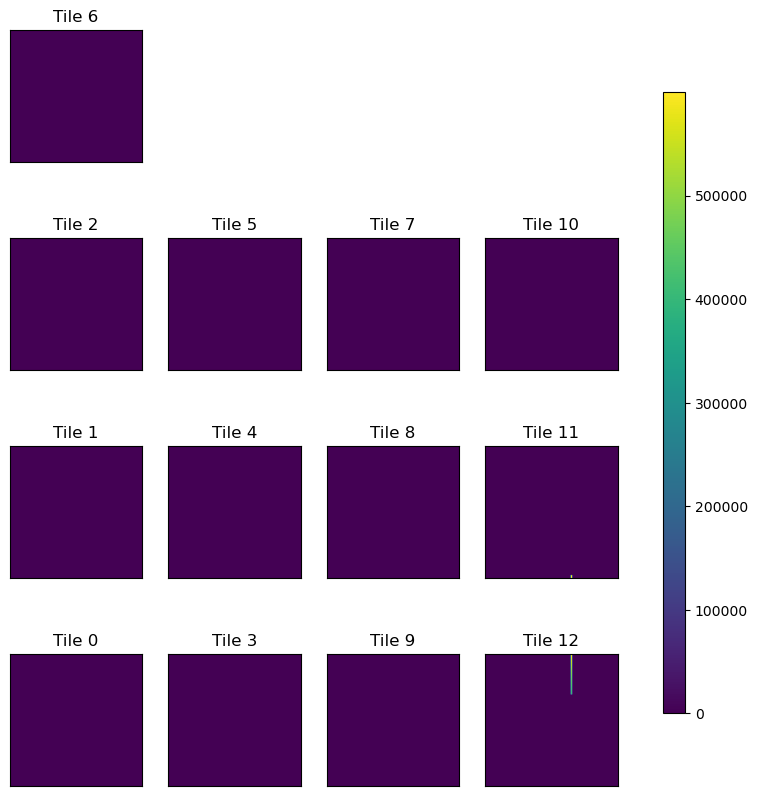

In [10]:
ecco.plot_tiles(mask_tiles, layout='latlon',rotate_to_latlon=True,show_tile_labels=True, show_colorbar=True);

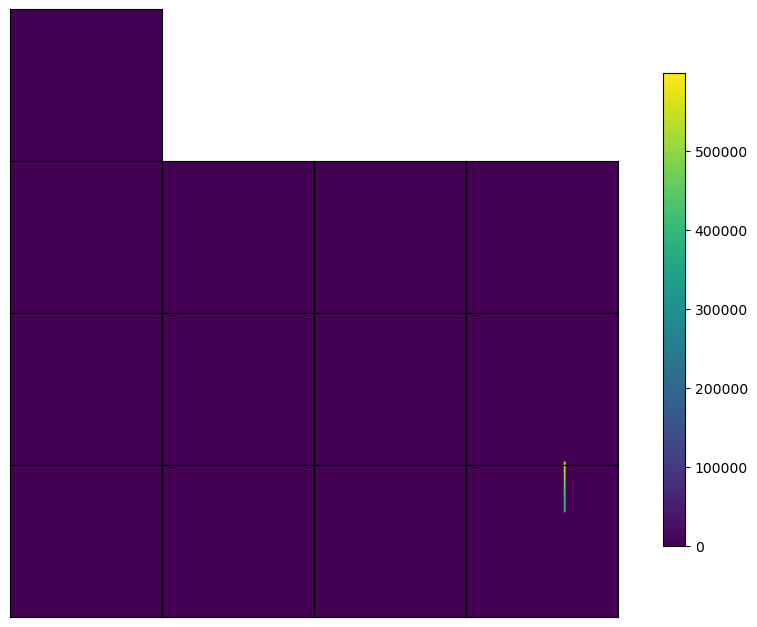

In [11]:
ecco.plot_tiles(mask_tiles, layout='latlon',rotate_to_latlon=True,show_tile_labels=False, show_colorbar=True);

We can see one line for where the Drake Passage gate is

In [14]:
mask_tiles.shape

(13, 90, 90)

In [19]:
mask_tile_da = xr.DataArray(mask_tiles, dims={'tile','i','j'})

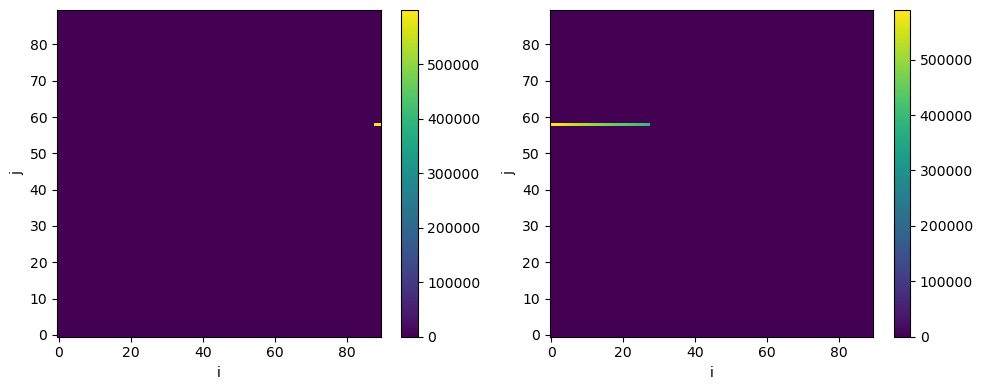

In [29]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=[10,4])
mask_tile_da.isel(tile=11).plot(ax=ax1)
mask_tile_da.isel(tile=12).plot(ax=ax2)
plt.tight_layout()

## Create my own mask

### Load ECCOv4r4 geometry file

In [3]:
grid_params_shortname = "ECCO_L4_GEOMETRY_LLC0090GRID_V4R4"
access_mode = 's3_open_fsspec'
download_root_dir = join(user_home_dir,'efs_ecco','ECCO_V4r4_PODAAC')
jsons_root_dir = join(user_home_dir,'efs_ecco','mzz-jsons')

In [4]:
grid_ds = ea.ecco_podaac_to_xrdataset(grid_params_shortname,\
                                      mode=access_mode,\
                                      download_root_dir=download_root_dir,\
                                      max_avail_frac=0.5,\
                                      jsons_root_dir=jsons_root_dir)

In [5]:
grid_ds

<xarray.Dataset> Size: 89MB
Dimensions:  (tile: 13, j: 90, i: 90, k: 50, k_p1: 51, nb: 4, j_g: 90, i_g: 90,
              nv: 2, k_l: 50, k_u: 50)
Coordinates: (12/20)
    XC       (tile, j, i) float32 421kB ...
    XC_bnds  (tile, j, i, nb) float32 2MB ...
    XG       (tile, j_g, i_g) float32 421kB ...
    YC       (tile, j, i) float32 421kB ...
    YC_bnds  (tile, j, i, nb) float32 2MB ...
    YG       (tile, j_g, i_g) float32 421kB ...
    ...       ...
  * j_g      (j_g) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * k        (k) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * k_l      (k_l) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * k_p1     (k_p1) int32 204B 0 1 2 3 4 5 6 7 8 ... 42 43 44 45 46 47 48 49 50
  * k_u      (k_u) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * tile     (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nb, nv
Data variables: (12/21)
    CS       (tile, j, i) float32 421kB ...
    Depth    (tile, j, i) float32 421kB ...
    PHrefC   (k) float32 200B ...
    PHrefF   (k_p1) float32 204B ...
    SN       (tile, j, i) float32 421kB ...
    drC      (k_p1) float32 204B ...
    ...       ...
    maskS    (k, tile, j_g, i) bool 5MB ...
    maskW    (k, tile, j, i_g) bool 5MB ...
    rA       (tile, j, i) float32 421kB ...
    rAs      (tile, j_g, i) float32 421kB ...
    rAw      (tile, j, i_g) float32 421kB ...
    rAz      (tile, j_g, i_g) float32 421kB ...
Attributes: (12/58)
    Conventions:                     CF-1.8, ACDD-1.3
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty and Ou Wang
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    references:                      ECCO Consortium, Fukumori, I., Wang, O.,...
    source:                          The ECCO V4r4 state estimate was produce...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         This dataset provides geometric paramete...
    title:                           ECCO Geometry Parameters for the Lat-Lon...
    uuid:                            87ff7d24-86e5-11eb-9c5f-f8f21e2ee3e0

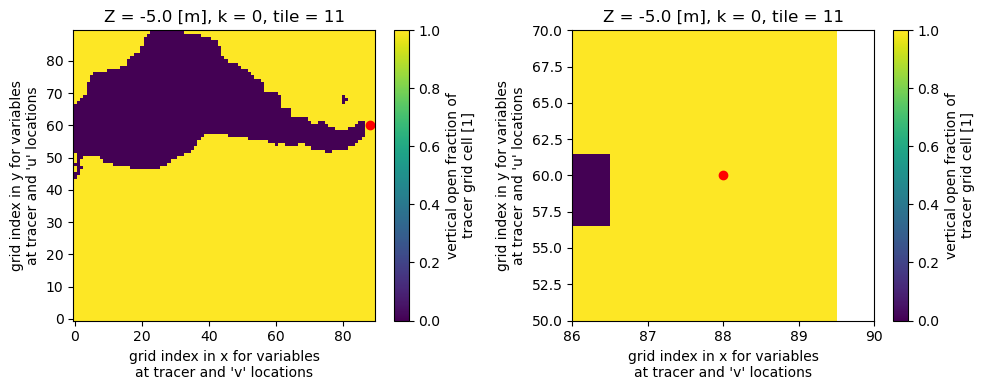

In [37]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=[10,4])
grid_ds.hFacC.isel(tile=11,k=0).plot(ax=ax1);
grid_ds.hFacC.isel(tile=11,k=0).plot(ax=ax2);
ax2.set_xlim(86,90)
ax2.set_ylim(50,70);
ax1.scatter(88,60,c='r')
ax2.scatter(88,60,c='r')
plt.tight_layout();

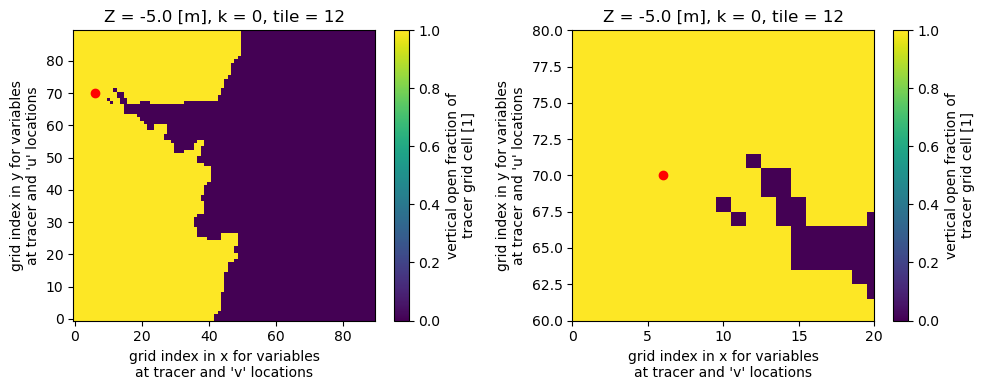

In [40]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=[10,4])
grid_ds.hFacC.isel(tile=12,k=0).plot(ax=ax1);
grid_ds.hFacC.isel(tile=12,k=0).plot(ax=ax2);
ax2.set_xlim(0,20)
ax2.set_ylim(60,80);
ax1.scatter(6,70,c='r')
ax2.scatter(6,70,c='r')
plt.tight_layout();

In [58]:
mask_ds = xr.where(grid_ds.hFacC>0,0,0) # make everything zero

In [63]:
# make the two select grid cells at the southern tip of Chile and WAP = 1
mask_pts_ds = mask_ds.isel(k=0)
mask_pts_ds[11,60,88] = 1
mask_pts_ds[12,70,6] = -1

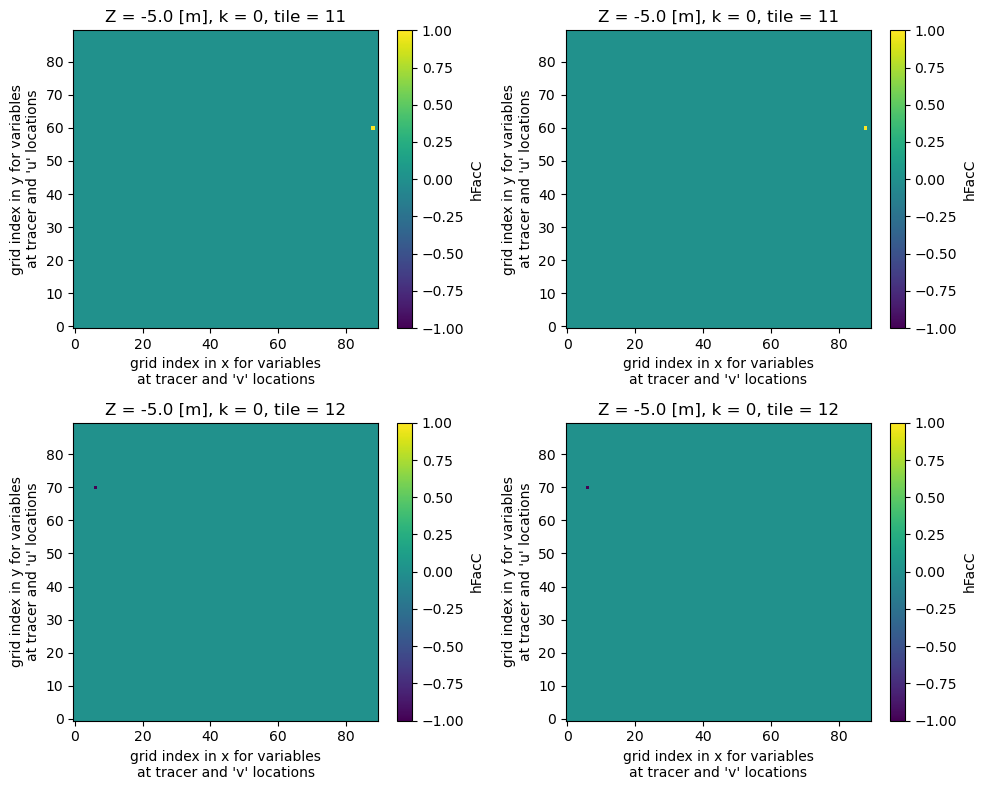

In [73]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=[10,8])
mask_pts_ds.isel(tile=11).plot(ax=ax1,vmin=-1,vmax=1);
mask_pts_ds.isel(tile=11).plot(ax=ax2,vmin=-1,vmax=1);
mask_pts_ds.isel(tile=12).plot(ax=ax3,vmin=-1,vmax=1);
mask_pts_ds.isel(tile=12).plot(ax=ax4,vmin=-1,vmax=1);
plt.tight_layout();

In [70]:
# save mask as compact, binary format
mask_compact = ecco.llc_tiles_to_compact(mask_pts_ds)

llc_tiles_to_faces: num_tiles,  13
llc_faces_to_compact: face 3 shape (90, 90)
llc_faces_to_compact: data_compact array shape (1170, 90)
llc_faces_to_compact: data_compact array dtype int64


In [72]:
mask_compact.astype('>f4').tofile('/efs_ecco/mzahn/'+'drake_ssh_mask.bin')

## Open mask to double check

In [74]:
input_dir = '/efs_ecco/mzahn/'
input_file = 'drake_ssh_mask.bin'

ssh_mask_tiles = ecco.read_llc_to_tiles(input_dir, input_file)

load_binary_array: loading file /efs_ecco/mzahn/drake_ssh_mask.bin
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4


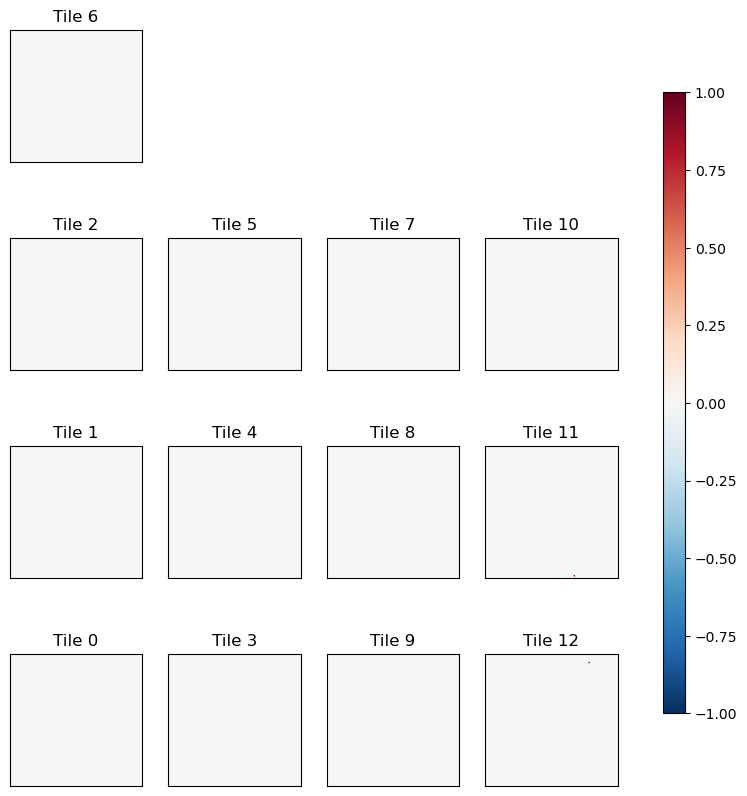

In [75]:
ecco.plot_tiles(ssh_mask_tiles, layout='latlon',rotate_to_latlon=True,show_tile_labels=True, show_colorbar=True);